# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

**Tasks**

1. Load the data, have a look at it and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

The `RMSE` metric on the test set should not be more than 48.

# Import libraries and open the dataset

In [74]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from lightgbm import LGBMRegressor
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

%matplotlib inline

In [75]:
try:
    taxi_df = pd.read_csv('datasets/taxi.csv', parse_dates=[0], index_col=[0])
except:
    print('Something went wrong during opening the file! Please check the file path first.')

taxi_df.sort_index(inplace=True)
taxi_df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [76]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [77]:
# checking for the missing values
taxi_df.isna().sum()

num_orders    0
dtype: int64

# Data preparation

## Fixing the `num_orders` column dtype

In [78]:
# looking a the max value in the column
taxi_df.num_orders.max()

119

> The max value is 119, while int8 range is ±127. Let's change it to this type in order to save some memory and speed up the work process.

In [79]:
taxi_df.num_orders = taxi_df.num_orders.astype('int8')

In [80]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int8 
dtypes: int8(1)
memory usage: 232.9 KB


> We have decreased the memory consumption almost 2 times!

## Resampling the data

In [81]:
#taxi_df = taxi_df.resample('1H').mean()
taxi_df = taxi_df.resample('1H').sum()

## Adding new features to the dataset

In [82]:
def make_features(data, setting = 1, max_lag=0, rolling_mean_size=0):
    if setting == 1:
        data['month'] = data.index.month.astype('int8')
        data['day_of_week'] = data.index.dayofweek.astype('int8')
        data['hour'] = data.index.hour.astype('int8')
    
    # Calculate lags for the `num_orders` column
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = round(data['num_orders'].shift(lag))#.astype('float32')
        
    # Calculate rolling mean for the 'num_orders' column
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean().astype('float32')
    data['num_orders'] = data['num_orders'].astype('float32')
    
    return data

make_features(taxi_df, setting = 1, rolling_mean_size=5)

,num_orders,month,day_of_week,hour,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124.0,3,3,0,NaN
2018-03-01 01:00:00,85.0,3,3,1,NaN
2018-03-01 02:00:00,71.0,3,3,2,NaN
2018-03-01 03:00:00,66.0,3,3,3,NaN
2018-03-01 04:00:00,43.0,3,3,4,NaN


# Data analysis

## Looking for correlations

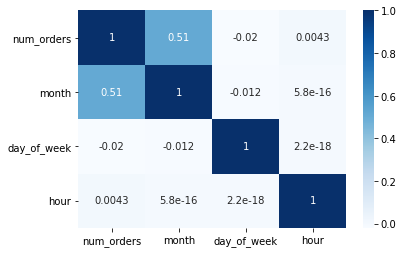

In [83]:
sns.heatmap(taxi_df[['num_orders', 'month', 'day_of_week', 'hour']].corr(), cmap='Blues', annot=True)
plt.show()

As we can see, `month` column value has strong positive correlation with `num_orders`. On the other hand, `hour` and `day_of_week` have no influence on `num_orders`.

## Data visualization

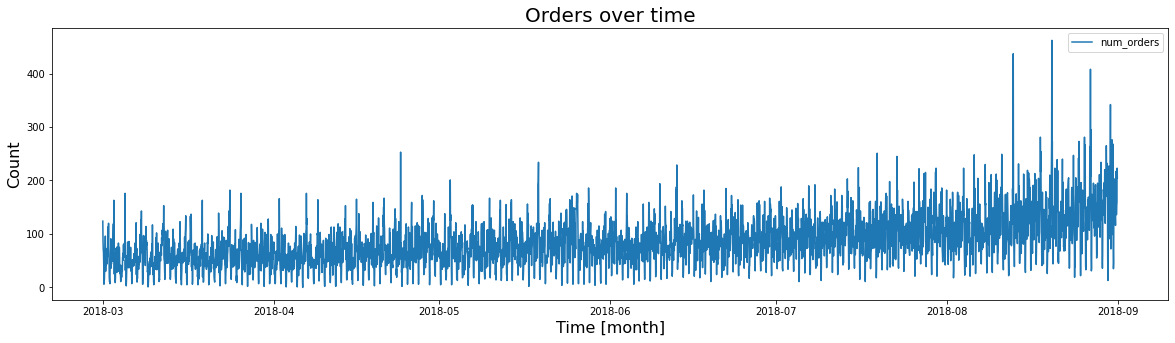

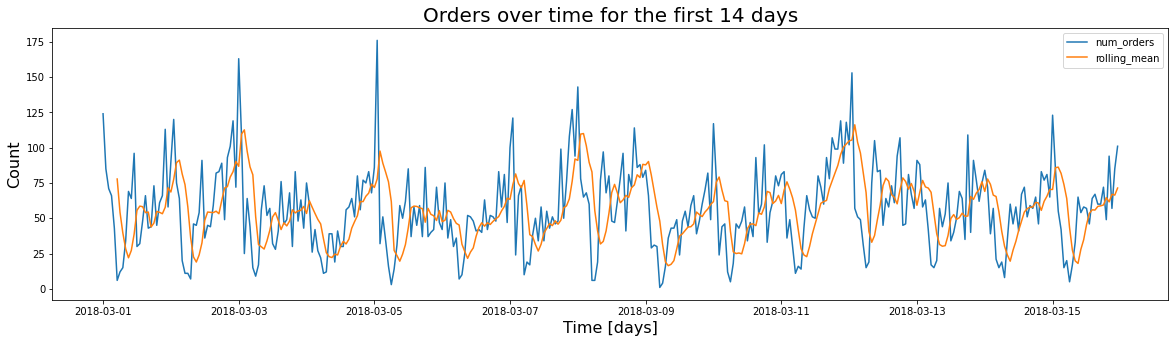

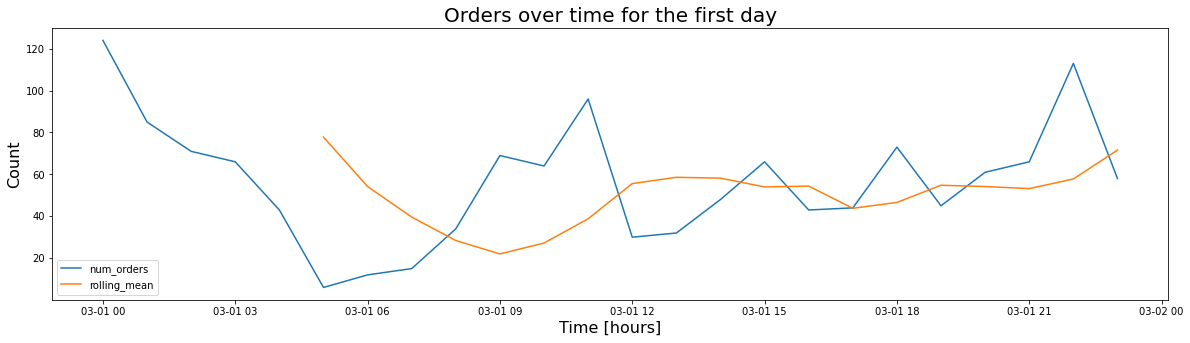

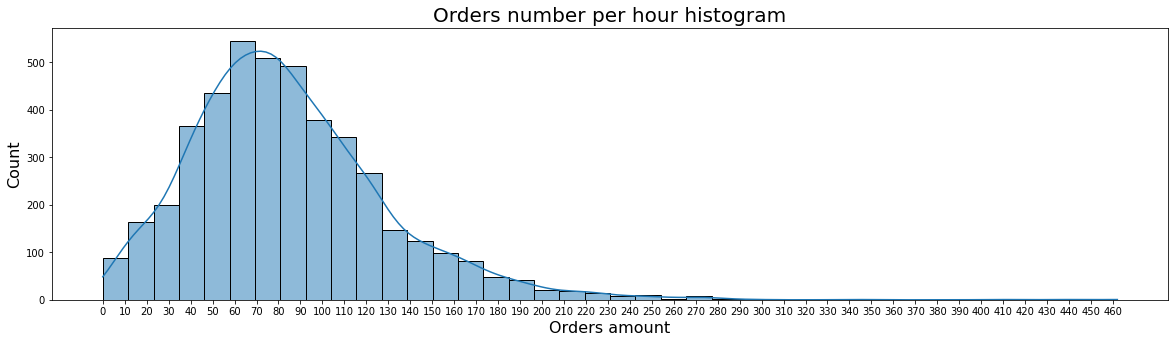

In [84]:
# plot the whole data
plt.figure(figsize=(20,5))
sns.lineplot(data=taxi_df, x=taxi_df.index, y='num_orders', legend=True)
#sns.lineplot(data=taxi_df, x=taxi_df.index, y='rolling_mean', legend=True)
plt.legend(labels=["num_orders"])#,"rolling_mean"])
plt.title('Orders over time', size=20)
plt.ylabel('Count', size=16)
plt.xlabel('Time [month]', size=16)

# plot partial data for only first 10 days
plt.figure(figsize=(20,5))
sns.lineplot(data=taxi_df.iloc[:360], x=taxi_df.index[:360], y='num_orders', legend=True)
sns.lineplot(data=taxi_df.iloc[:360], x=taxi_df.index[:360], y='rolling_mean', legend=True)
plt.legend(labels=["num_orders","rolling_mean"])
plt.title('Orders over time for the first 14 days', size=20)
plt.ylabel('Count', size=16)
plt.xlabel('Time [days]', size=16)

# plot partial data for only the first day
plt.figure(figsize=(20,5))
sns.lineplot(data=taxi_df.iloc[:24], x=taxi_df.index[:24], y='num_orders', legend=True)
sns.lineplot(data=taxi_df.iloc[:24], x=taxi_df.index[:24], y='rolling_mean', legend=True)
plt.legend(labels=["num_orders","rolling_mean"])
plt.title('Orders over time for the first day', size=20)
plt.ylabel('Count', size=16)
plt.xlabel('Time [hours]', size=16)

# plot the orders histogram

# setting up x_tics values
x_tics = list(range(0, int(taxi_df.num_orders.max()+5), 10))

plt.figure(figsize=(20,5))
sns.histplot(taxi_df.num_orders, bins=40, kde=True)
plt.title('Orders number per hour histogram', size=20)
plt.xticks(x_tics)
plt.ylabel('Count', size=16)
plt.xlabel('Orders amount', size=16)


plt.show()

We can observe some increase in orders near the end of the dataset. We can see, that orders number increase in the morning (between 9 am and 12 am), peaks occur at nights (between 9 pm and 3 am). Orders number histogram shows normal distribution, shifted closer to zero, and with most frequent values are between 50 and 90.

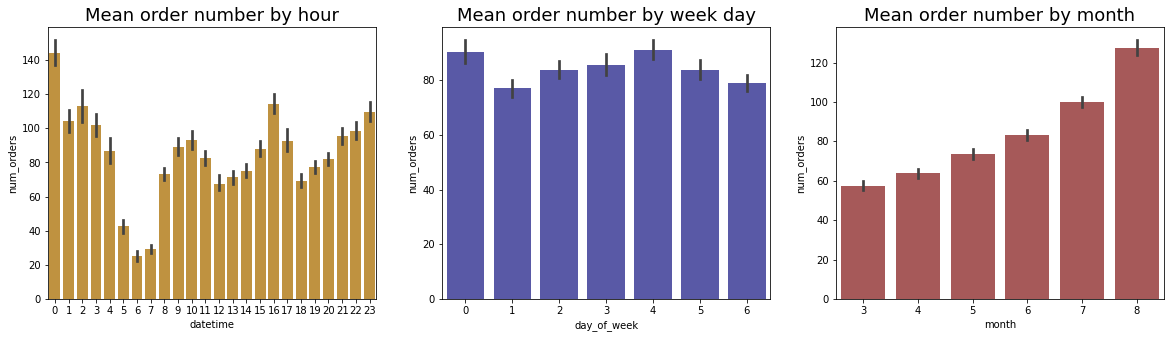

In [85]:
plt.figure(figsize=(20, 5))

plt.subplot(131)
sns.barplot(data=taxi_df, x=taxi_df.index.hour, y='num_orders', color="orange", saturation=.5)
plt.title('Mean order number by hour', size=18)

plt.subplot(132)
sns.barplot(data=taxi_df, x='day_of_week', y='num_orders', color="blue", saturation=.3)
plt.title('Mean order number by week day', size=18)

plt.subplot(133)
sns.barplot(data=taxi_df, x='month', y='num_orders', color="red", saturation=.3)
plt.title('Mean order number by month', size=18)

plt.show()

We can observe, that the highest taxi demand is at midnight, and the lowest is between 5-7 am. Furthermore, the orders mean number steadily increase in this dataset and gets its peak on August (the last month in the data frame)

## Data seasonality

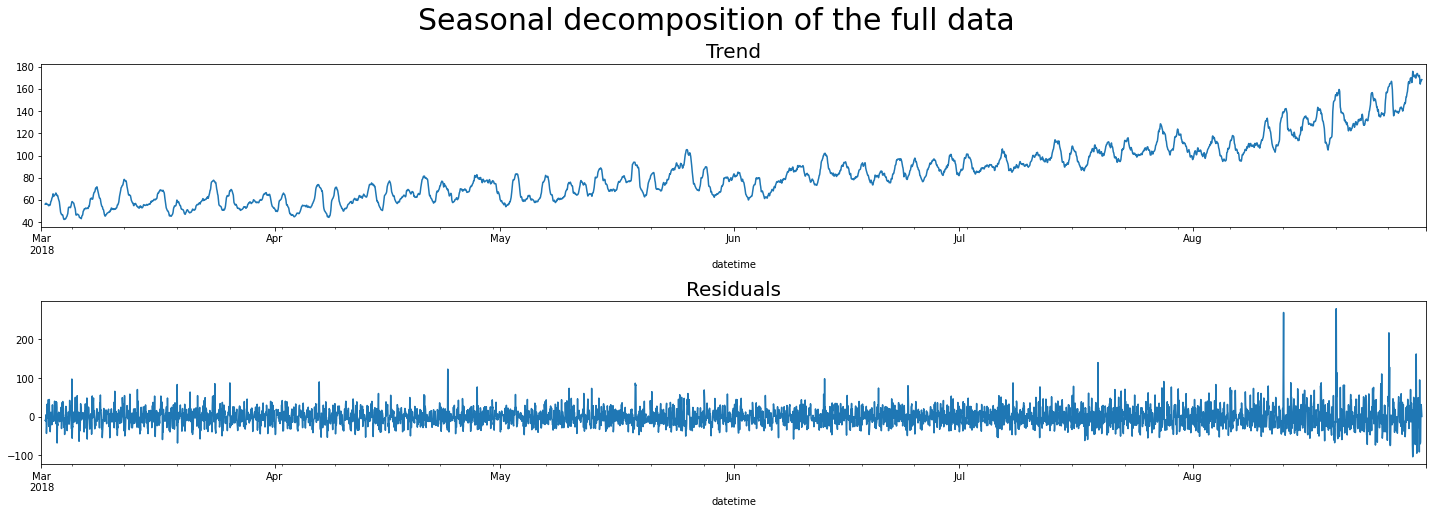

In [86]:
# decomposing the data
decomposed = seasonal_decompose(taxi_df.num_orders)

plt.figure(figsize=(20, 10))
plt.suptitle('Seasonal decomposition of the full data', size=30)

# plot a chart for the trend
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
#plt.title=('Trend')
plt.gca().set_title('Trend', size=20)

# # plot a chart for the seasonality
# plt.subplot(312)
# decomposed.seasonal.plot(ax=plt.gca())
# #plt.title=('Seasonality')
# plt.gca().set_title('Seasonality', size=20)

#plot a chart for the residuals 
plt.subplot(312)
decomposed.resid.plot(ax=plt.gca())
#plt.title('Residuals')
plt.gca().set_title('Residuals', size=20)

plt.tight_layout()
plt.show()

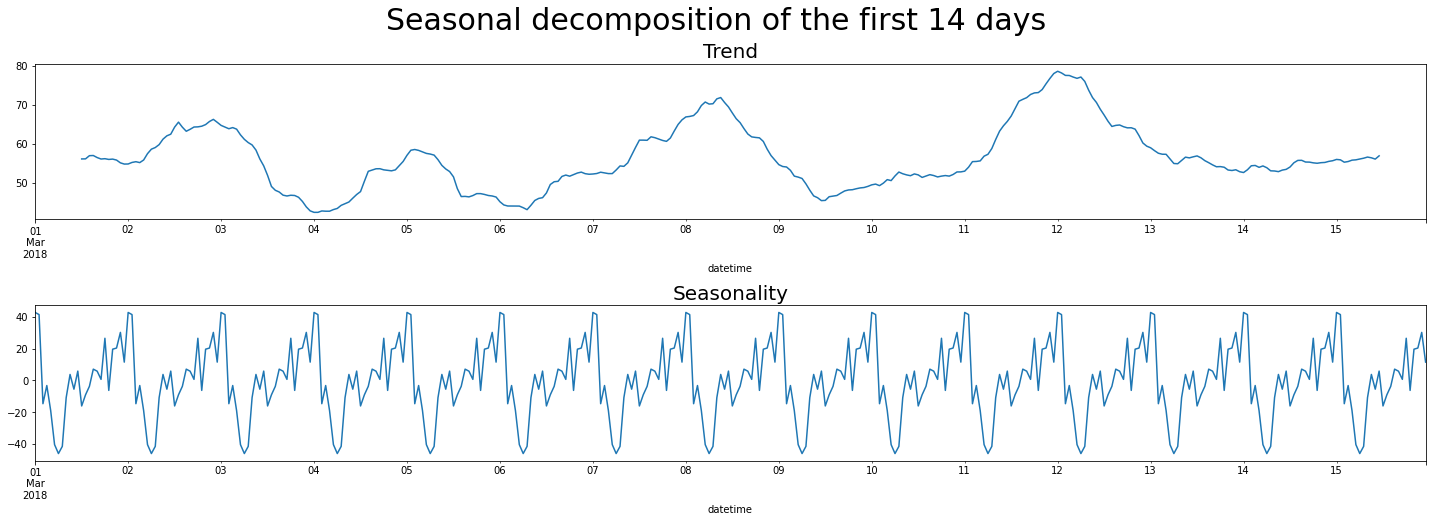

In [87]:
# decomposing the data of the first 14 days
decomposed = seasonal_decompose(taxi_df.num_orders[:360])

plt.figure(figsize=(20, 10))
plt.suptitle('Seasonal decomposition of the first 14 days', size=30)
# plot a chart for the trend
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
#plt.title=('Trend')
plt.gca().set_title('Trend', size=20)

# plot a chart for the seasonality
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
#plt.title=('Seasonality')
plt.gca().set_title('Seasonality', size=20)

plt.tight_layout()
plt.show()

Seasonal decomposition has given us valuable information about the data:
1. The number of orders increases during summer and at beginning of autumn.
2. The residuals show that there is a higher variance of the number of orders in the above-mentioned period. 
3. Seasonality shows very similar patterns every day - good news.

## Data stationarity (Augmented Dickey-Fuller test)

Let's perform a `Augmented Dickey-Fuller test` to see whether the `num_orders` column is a stationary data.

In [88]:
adfuller(taxi_df.num_orders)

(-3.068924289027947,
 0.02894005140261361,
 30,
 4385,
 {'1%': -3.431842162413052,
  '5%': -2.8621993540813637,
  '10%': -2.567120978470452},
 41728.71357827463)

The p-value (~0.029) of the `Augmented Dickey-Fuller test` suggests that the tested data is stationary. Thus, we can use Autoregressive models to predict future results. 

# Model training

Making a function to test our models

In [89]:
def model_tester(model):
    # fitting the model and calculating the fitting time
    start_time = time.time()
    model.fit(X_train, y_train)
    finish_time = time.time()
    fit_time = round(finish_time - start_time, 4)
        
    # making predictions and calculating the prediction time
    start_time = time.time()
    y_test_pred = model.predict(X_test)
    finish_time = time.time()
    pred_time = round(finish_time - start_time, 4)
    
    # calculating the result
    rmse = round(mean_squared_error(y_test, y_test_pred) ** 0.5, 2)
    return rmse, fit_time, pred_time, y_test_pred

## One-hot-encoding

We will perform one-hot-encoding for columns `hour` and `day_of_week`. We will not do that for the `month` column because there is a strong positive correlation between `num_orders` and `month`.

In [90]:
# making dummies for `hour`, and `day_of_week`
hours = pd.get_dummies(taxi_df.hour, prefix='hour')
days = pd.get_dummies(taxi_df.day_of_week, prefix='day')

# concating dummy columns with the original dataframe
taxi_df = pd.concat([taxi_df, hours, days], axis=1)

# deleting the previous columns
taxi_df = taxi_df.drop(['hour', 'day_of_week'], axis=1)

## Splitting the data

In [91]:
def data_splitter(data):
    # splitting the data
    train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=42)

    # Remove rows with NaN values
    train = train.dropna()

    # assigning features and targets for train and test samples
    X_train = train.drop('num_orders', axis=1)
    y_train = train['num_orders']
    
    X_test = test.drop('num_orders', axis=1)
    y_test = test['num_orders']
    
    return X_train, y_train, X_test, y_test

## Features
Making new features with random `max_lag` and `rolling_mean` - we will optimize them later

In [92]:
# making data frame copies
test_df = taxi_df.copy()

# making new features with random `max_lag` and `rolling_mean` - we will optimize them later
make_features(test_df, setting = 0, max_lag=5, rolling_mean_size=5)

# splitting the data
X_train, y_train, X_test, y_test = data_splitter(test_df)

## Linear Regression

In [94]:
# initializing the model
model = LinearRegression()

lr_rmse, lr_fit_time, lr_pred_time, lr_pred_y = model_tester(model)

print(f"Linear regression RMSE for the test set: {lr_rmse}")
print(f"Fitting time: {lr_fit_time} [sec]")
print(f"Prediction time: {lr_pred_time} [sec]")

Linear regression RMSE for the test set: 46.33
Fitting time: 0.007 [sec]
Prediction time: 0.001 [sec]


## Random Forest Regression

In [95]:
%%time

# settings
est_range = list(range(10, 100, 10))
depth_range = list(range(10, 100, 10))

rf_best_model= None
rf_best_result = 3000
rf_best_depth = 0
rf_best_est = 0
rf_best_fit_time = 0
rf_best_pred_time = 0
rf_best_pred_y = []

for est in est_range:
    #print('n_estimators: ', est)
    for depth in depth_range:
        model = RandomForestRegressor(random_state=42, max_depth=depth, n_estimators = est, n_jobs=-1)

        rf_rmse, fit_time, pred_time, rf_pred_y = model_tester(model)
        #print("max_depth:", depth, "; RMSE:", rf_rmse)
        
        # writing down the best results
        if rf_rmse < rf_best_result:
            rf_best_model = model
            rf_best_result = rf_rmse
            rf_best_depth = depth
            rf_best_est = est
            rf_best_fit_time = fit_time
            rf_best_pred_time = pred_time
            rf_best_pred_y = rf_pred_y
            
    #print('=' * 35)
# showing the best model's parameters and working times    
print(f"Best Random Forest Regression model RMSE for the test set: {rf_best_result}")
print(f"Model's params: n_estimators = {rf_best_est}, max_depth = {rf_best_depth}")
print(f"Fitting time: {rf_best_fit_time} [sec]")
print(f"Prediction time: {rf_best_pred_time} [sec]")

Best Random Forest Regression model RMSE for the test set: 45.87
Model's params: n_estimators = 90, max_depth = 20
Fitting time: 0.4851 [sec]
Prediction time: 0.1111 [sec]
Wall time: 36.5 s


## LightGBMRegressor

In [96]:
%%time

lgbm_best_model= None
lgbm_best_result = 3000
lgbm_best_depth = 0
lgbm_best_est = 0
lgbm_best_learning_rate = 0
lgbm_best_fit_time = 0
lgbm_best_pred_time = 0
lgbm_best_pred_y = []

# Settings:
learning_range = [0.1, 0.2, 0.3]
est_range = range(10, 201, 30)
leaves_range = range(5, 30, 2)

for rate in learning_range:
    #print('learning_rate: ', rate)
    #print('')
    for est in est_range:
        #print('n_estimators: ', est)
        for leaves in leaves_range:
            model = LGBMRegressor(learning_rate=rate, num_leaves=leaves, n_estimators=est, n_jobs=-1,
                                  random_state=42)
    
            lgbm_rmse, fit_time, pred_time, lgbm_pred_y = model_tester(model)
            #print("max_depth:", depth, "; RMSE:", rf_rmse)

            # writing down the best results
            #print("num_leaves:", leaves, "; RMSE:", lgbm_rmse)
            if lgbm_rmse < lgbm_best_result:
                lgbm_best_model = model
                lgbm_best_result = lgbm_rmse
                lgbm_best_leaves = leaves
                lgbm_best_est = est
                lgbm_best_learning_rate = rate
                lgbm_best_fit_time = fit_time
                lgbm_best_pred_time = pred_time
                lgbm_best_pred_y = lgbm_pred_y
        #print('=' * 35)

        
# showing the best model's parameters and working times    
print(f"LightGBMRegressor best model's RMSE for the test set: {lgbm_best_result}")
print(f"Best hyperparameters: \nlearning_rate: {lgbm_best_learning_rate}; n_estimators: {lgbm_best_est}; num_leaves: {lgbm_best_leaves}")
print(f"Fitting time: {lgbm_best_fit_time} [sec]")
print(f"Prediction time: {lgbm_best_pred_time} [sec]")

LightGBMRegressor best model's RMSE for the test set: 42.02
Best hyperparameters: 
learning_rate: 0.3; n_estimators: 190; num_leaves: 5
Fitting time: 0.036 [sec]
Prediction time: 0.003 [sec]
Wall time: 13.5 s


## XGBoostRegressor

In [97]:
%%time

xgb_best_model= None
xgb_best_result = 3000
xgb_best_depth = 0
xgb_best_est = 0
xgb_best_learning_rate = 0
xgb_best_fit_time = 0
xgb_best_pred_time = 0
xgb_best_pred_y = []

# Settings:
learning_range = [0.1, 0.3, 0.5]
depth_range = range(1, 17, 2)

for rate in learning_range:
    #print(f'learning_rate: {rate}')
    for depth in depth_range:
        model = xgb.XGBRegressor(learning_rate=rate, max_depth=depth, n_jobs=-1, random_state=42)
        
        xgb_rmse, fit_time, pred_time, xgb_pred_y = model_tester(model)

        #print("max_depth:", depth, "; RMSE:", xgb_rmse)
        if xgb_rmse < xgb_best_result:
            xgb_best_model = model
            xgb_best_result = xgb_rmse
            xgb_best_depth = depth
            xgb_best_learning_rate = rate
            xgb_best_fit_time = fit_time
            xgb_best_pred_time = pred_time
            xgb_best_pred_y = xgb_pred_y
    #print("=" * 35)

# showing the best model's parameters and working times    
print(f"XGBoostRegressor best model's RMSE for the test set: {xgb_best_result}")
print(f"Best hyperparameters: \nlearning_rate: {xgb_best_learning_rate}; max_depth: {xgb_best_depth}")
print(f"Fitting time: {xgb_best_fit_time} [sec]")
print(f"Prediction time: {xgb_best_pred_time} [sec]")

XGBoostRegressor best model's RMSE for the test set: 42.76
Best hyperparameters: 
learning_rate: 0.1; max_depth: 5
Fitting time: 0.197 [sec]
Prediction time: 0.004 [sec]
Wall time: 8.14 s


# Final model. `lag` and `rolling_mean` parameters optimization

## Final model: LightGBMRegressor

Once we have found the best model, we can use its hyperparameters to tune find the best parameters for `lag` and `rolling_mean` values in our function `make_features`.

In [98]:
%%time

# settings
lag_range = list(range(1, 30, 2))
roll_mean_range = list(range(1, 30, 2))

final_best_model= None
final_best_result = 3000
final_best_fit_time = 0
final_best_pred_time = 0
final_best_lag = 0
final_best_roll = 0
final_best_y = []
                
for lag in lag_range:
    #print(f'max_lag = {lag}')
    for roll in roll_mean_range:
        # making copy of the data
        test = taxi_df.copy()
        make_features(test_df, setting=0, max_lag=lag, rolling_mean_size=roll)
        
        # splitting the data into train and test sets
        X_train, y_train, X_test, y_test = data_splitter(test_df)
        
        # initializing the model
        model = LGBMRegressor(learning_rate=lgbm_best_learning_rate, num_leaves=lgbm_best_leaves,
                              n_estimators=lgbm_best_est, n_jobs=-1, random_state=42)

        lgbm_rmse, fit_time, pred_time, final_y = model_tester(model)
        #print("rolling_mean_size:", roll, "; RMSE:", lr_rmse)
        
         # writing down the best results
        if lgbm_rmse < final_best_result:
            final_best_model = model
            final_best_result = lgbm_rmse
            final_best_fit_time = fit_time
            final_best_pred_time = pred_time
            final_best_lag = lag
            final_best_roll = roll
            final_best_y = final_y
    #print('=' * 35)

print(f"LightGBMRegressor best model's RMSE for the test set: {final_best_result}")
print(f"Model's params: lag = {final_best_lag}, rolling_mean_size = {final_best_roll}")
print(f"Fitting time: {final_best_fit_time} [sec]")
print(f"Prediction time: {final_best_pred_time} [sec]")

LightGBMRegressor best model's RMSE for the test set: 39.11
Model's params: lag = 25, rolling_mean_size = 9
Fitting time: 0.059 [sec]
Prediction time: 0.003 [sec]
Wall time: 16 s


# Performance Comparison

In [99]:
# Create a DataFrame with results

model_names = ['Linear Reg', 'Random Forest', 'LightGBM',
               'XGBoost', 'LightGBM_optimized']
rmse_values = [lr_rmse, rf_best_result, lgbm_best_result, xgb_best_result, final_best_result]
fitting_time = [lr_fit_time, rf_best_fit_time, lgbm_best_fit_time, xgb_best_fit_time, final_best_fit_time]
prediction_time = [lr_pred_time, rf_best_pred_time, lgbm_best_pred_time, xgb_best_pred_time, final_best_pred_time]

result_df = pd.DataFrame(data=zip(model_names, rmse_values, fitting_time, prediction_time),
                         columns=['model', 'rmse', 'fitting time [s]', 'prediction time [s]'])

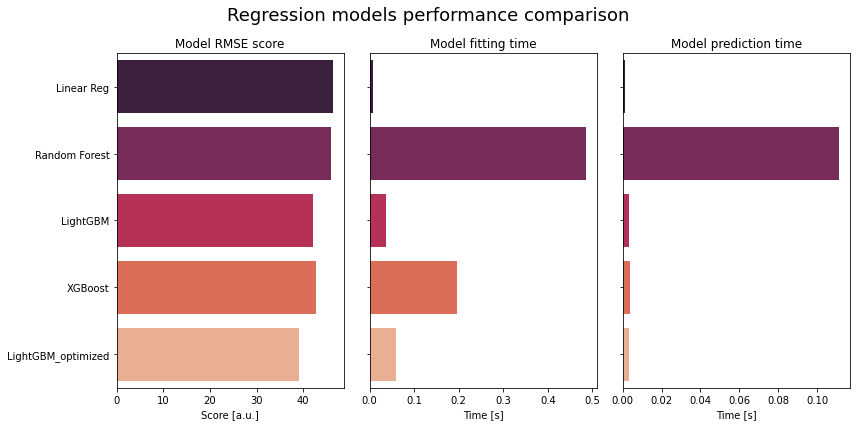

In [174]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

palette = 'rocket'

sns.barplot(x=result_df.rmse, y=result_df.model, ax=ax[0], palette=palette)
ax[0].set(xlabel='Score [a.u.]', ylabel='', title='Model RMSE score')

sns.barplot(x=result_df['fitting time [s]'], y=result_df.model, ax=ax[1], palette=palette)
ax[1].set(yticklabels=[], title='Model fitting time', xlabel='Time [s]', ylabel='')

sns.barplot(x=result_df['prediction time [s]'], y=result_df.model, ax=ax[2], palette=palette)
ax[2].set(yticklabels=[], title='Model prediction time', xlabel='Time [s]', ylabel='')

fig.suptitle('Regression models performance comparison', fontsize=18)
plt.tight_layout()
plt.show()

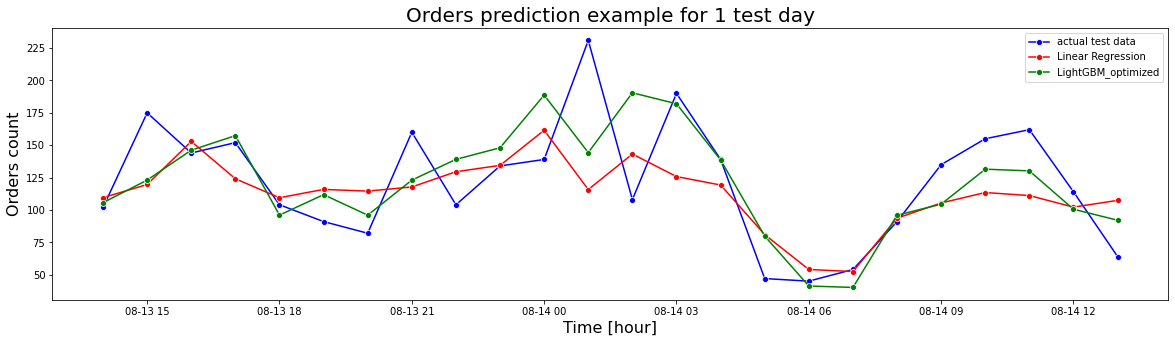

In [176]:
test_df = pd.DataFrame({'actual': y_test, 'Linear Regression': lr_pred_y,'LightGBM_optimized': final_best_y})

# plot the whole data
plt.figure(figsize=(20,5))
sns.lineplot(data=test_df[:24], x=test_df.index[:24], y='actual', legend=True, marker="o", color='blue')
sns.lineplot(data=test_df[:24], x=test_df.index[:24], y='Linear Regression', legend=True, marker="o", color='red')
sns.lineplot(data=test_df[:24], x=test_df.index[:24], y='LightGBM_optimized', legend=True, marker="o",color='green')
plt.legend(labels=['actual test data', 'Linear Regression', 'LightGBM_optimized'])
plt.title('Orders prediction example for 1 test day', size=20)
plt.ylabel('Orders count', size=16)
plt.xlabel('Time [hour]', size=16)

plt.show()

## Feature importances of the best model

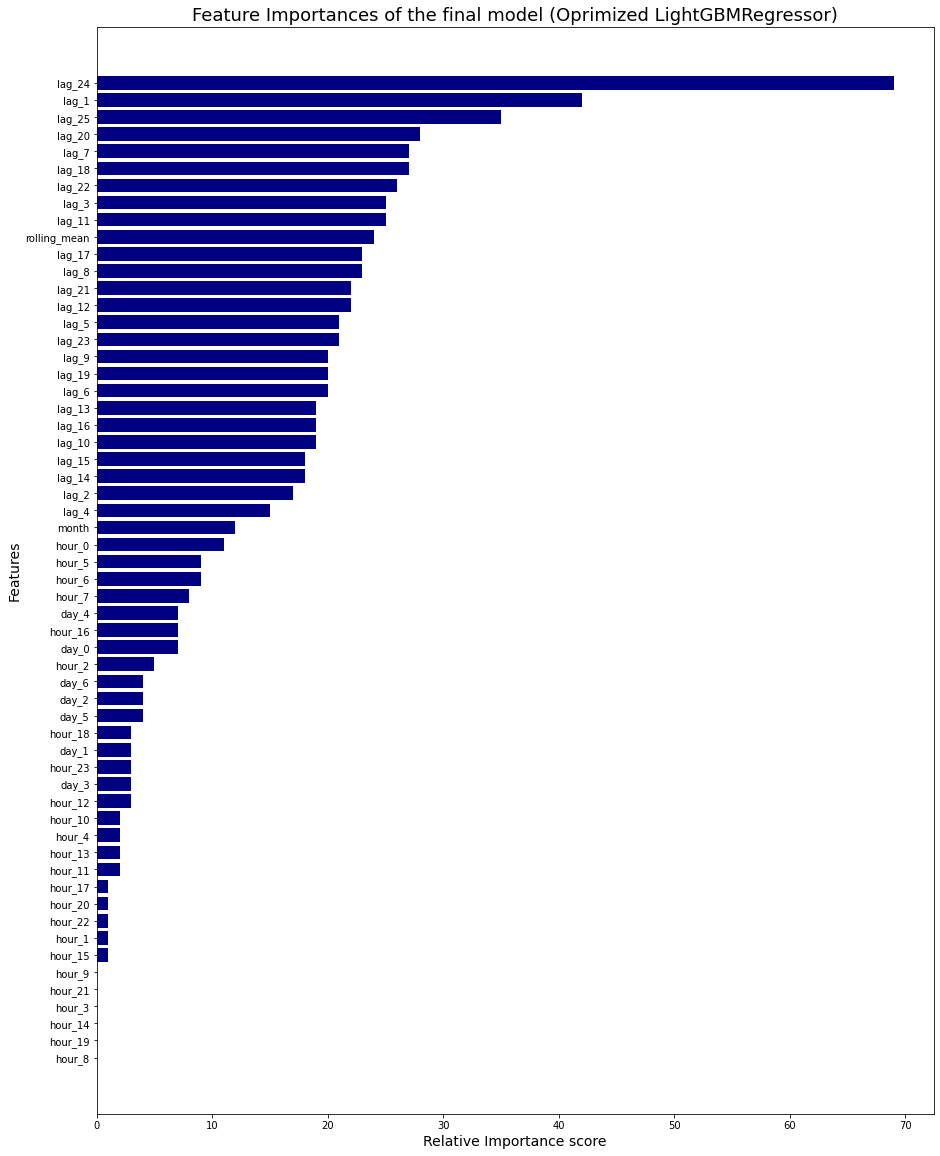

In [71]:
#plot a curve showing the relative importance of each feature on the model
features=X_train.columns.tolist()
importances=final_best_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(15,20))
plt.title('Feature Importances of the final model (Oprimized LightGBMRegressor)', fontsize=18)
plt.barh(range(len(indices)), importances[indices], color='navy', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.show()

# Conclusion

In this section, we have trained and tested the following algorithms:

|Algorithm            |Encoding              |Scaling        |Tuned Hyperparamteres                  |
|---------------------|----------------------|---------------|---------------------------------------|
|Linear Regression    |One hot encoding      |None           |None                                   |
|Random Forest        |One hot encoding      |None           |max_depth, n_estimators                |
|LightGBM             |One hot encoding      |None           |learning_rate, num_leaves, n_estimators|
|XGBoost              |One hot encoding      |None           |learning_rate, max_depth               |
|LightGBM_optimized   |One hot encoding      |None           |lag, rolling_mean                      |
    
**Best achieved results:**  
    
|Algorithm	      |RMSE	|Fitting Time [s]|	Prediction Time [s] |
|-----------------|-----|----------------|-----------------------|
|Linear Regression|46.33 |	0.0080	     |0.001                    |
|Random Forest    |45.87 |	0.4721	     |0.111                    |
|LightGBM         |42.02 |	0.0370	     |0.003                    |
|XGBoost          |42.76 |	0.1880	     |0.004                    |
|LightGBM_optimized|39.11 |	0.0540	     |0.003                    |

The Linear Regression model has served here as a basic model for a sanity check and for comparison with the others.

We can see, that the `Linear Regression` had the worst performance of all the tested models with RMSE = $\pm$46.33.
The best RSME value has been shown by the `LightGBM` and later we have done the final modification of the `lags` and `rolling_mean` features. This resulted in RMSE = $\pm$39.11.

**This being said, the `LightGBM` model is a clear winner for predicting the number of taxi orders. It combines the best RMSE value, together with rapid fitting and prediction time.**

As we can observe, the most important features for predicting the number of orders are: `lag_1` and `lag_24`. Basically, the number of orders of the previous hour and the previous day at the same time. The best `rolling_mean` value was found to be equal to 9. `month` value had also some impact on the predictions.